<a href="https://colab.research.google.com/github/wafer110/Python-DataMining-MachineLearning/blob/master/FinalProject_WeiHuaHsu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Packages  

In [2]:
import pandas as pd 
import numpy as np
import math
# Plotting
import matplotlib.pylab as plt
import matplotlib.pyplot as plt

# Ignore warnings
import warnings; warnings.filterwarnings("ignore")

# Data Mining Techniques
from sklearn.model_selection import train_test_split
# Stratified K-fold Cross Validation
from sklearn.model_selection import StratifiedKFold
# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
!pip install wittgenstein  # JRip
import wittgenstein as lw
# Evaluate Classification
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score
from sklearn.metrics import recall_score, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
# Friedman & Nemenyi test
import scipy.stats as ss
!pip install scikit_posthocs
import scikit_posthocs as sp
# UMAP
#!pip install umap-learn[plot]
#!pip install holoviews
#!pip install -U ipykernel
#import umap
#import umap.plot


#from google.colab import files


#from sklearn.datasets import make_classification

     |████████████████████████████████| 81kB 3.1MB/s 


## Import Data sets

In [2]:
# Get verification code for reading data through Google Drive
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [3]:
# Read data set
BCdata_Sup = '/content/drive/MyDrive/Colab Notebooks/ML_DataMining/Final Project/TNBC_wafer_Supervised.csv'
TNBC = pd.read_csv(BCdata_Sup)
print(TNBC.shape)
TNBC.head(3)

(23236, 19)


,Race_Ethnicity27,Race_Ethnicity7,Young_Old,VeryYoung_VeryOld,Age50,Age40,Age30,Age_Group,Age_At_Diagnosis,Survival_Months,Two_Years_Survival,Five_Years_Survival,Causes_Of_Death,Vital_Status,Lympth_Nodes_Positive,Tumor_Sizecm,Tumor_Grade,NPI_Prognosis,Marital_Status
0,White,1,2,3,2,2,2,6,75,6,2,2,Alive,1,0,8.2,0,5,4
1,Black,2,2,2,2,2,2,5,61,10,2,2,Alive,1,1,1.7,3,3,3
2,White,1,2,2,2,2,2,5,60,2,2,2,Alive,1,1,2.1,3,3,1


# Classification Methods  
  
- Select Attributes

In [4]:
# Create training and testing Data
X = TNBC.iloc[:,[1,8,11,13,14,15,16,17,18]]  # [11] Five_Years_Survival
y = TNBC.iloc[:,10]  # [9] Survival_Months, [10] Two_Years_Survival

# Change y label from 1, 2 to 1, 0 
# 0: <=2Years (9927); 1: >2Years (13309)
y[y == 2] = 0

## Functions for evaluating Classifiers  

### *def)* 10-fold CV Evaluations

In [5]:
def CVClassifier_Eval(classifier, seed):
  # Stratified K-fold Cross-Validation
  SKfold = StratifiedKFold(n_splits = 10, random_state = seed, shuffle = True)
  # Fit a Classification model
  clf = classifier
  # Evaluation
  accuracy = cross_val_score(clf, X, y, cv = SKfold, scoring = 'accuracy')
  precision = cross_val_score(clf, X, y, cv = SKfold, scoring = 'precision')
  recall = cross_val_score(clf, X, y, cv = SKfold, scoring = 'recall')
  f1 = cross_val_score(clf, X, y, cv = SKfold, scoring = 'f1')
  # Confusion Matrix (not 10-fold CV)
  y_pred = cross_val_predict(clf, X, y, cv = SKfold)
  conf_matr = confusion_matrix(y, y_pred)
  # Print the results
  print(f'Accuracy: {np.mean(accuracy)}')
  print(f'Precision: {np.mean(precision)}')
  print(f'Recall: {np.mean(recall)}')
  print(f'F-Measure: {np.mean(f1)}') 
  print('Confusion Matrix:') 
  print(conf_matr)

### *def)* AUC Curve by Training Size

In [6]:
def AUC_Curve(classifier, seed, clf_name):
  training_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
  AUC_train = []
  AUC_test = []
  
  for i in training_sizes:
    # looping through different training size
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        train_size = i,
                                                        random_state = seed)
    # fit a Classification model
    clf = classifier
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    # calculate the mean of AUC score by 10-fold CV
    train_scores = cross_val_score(clf, X_train, y_train, cv = 10, 
                                   scoring = 'roc_auc').mean()
    test_scores = cross_val_score(clf, X_test, y_test, cv = 10,
                                  scoring = 'roc_auc').mean()
    AUC_train.append(train_scores)
    AUC_test.append(test_scores)
    # plotting
  plt.figure(figsize=(8, 5.5))
  plt.plot(training_sizes, AUC_train, 'c^-', label = 'training')
  plt.plot(training_sizes, AUC_test, 'C1o-', label = 'testing')
  plt.legend(frameon = True, loc = 'bottom right')
  plt.title(clf_name, size = 15)
  plt.xlabel('Training Size', size = 13)
  plt.ylabel('AUC Score', size = 13)

### *def)* ROC Curve

In [7]:
def ROC_Curve(classifier, clf_name, train_size):
  # split into train/test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      train_size = train_size, 
                                                      random_state = 309)
  # generate a no skill prediction (majority class)
  ns_probs = [0 for _ in range(len(y_test))]
  # fit a model
  clf = classifier
  clf.fit(X_train, y_train)
  # predict probabilities
  lr_probs = clf.predict_proba(X_test)
  lr_probs2 = clf.predict_proba(X_train)
  # keep probabilities for the positive outcome only
  lr_probs = lr_probs[:, 1]
  lr_probs2 = lr_probs2[:,1]
  # calculate scores
  ns_auc = roc_auc_score(y_test, ns_probs)
  lr_auc = roc_auc_score(y_test, lr_probs)
  # summarize scores
  print('No Skill : ROC AUC=%.3f' % (ns_auc))
  print(clf_name, ': ROC AUC=%.3f' % (lr_auc))
  # calculate roc curves
  ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
  lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
  # plot the roc curve for the model
  plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
  plt.plot(lr_fpr, lr_tpr, marker='.', label=clf_name)
  # axis title & labels
  plt.title("ROC Curve", size = 18)
  plt.xlabel('False Positive Rate', size = 15)
  plt.ylabel('True Positive Rate', size = 15)
  # show the legend
  plt.legend()
  # set graph size
  fig = plt.gcf()
  fig.set_size_inches(8, 5.5)
  # show the plot
  plt.show()

## Logistic Regression   

In [ ]:
# Classification Model
Logistic = LogisticRegression(solver='lbfgs')

In [ ]:
# 10-fold Cross Validation Evaluation
CVClassifier_Eval(classifier = Logistic, seed = 39)

Accuracy: 0.6478310141124118
Precision: 0.6557677375772022
Recall: 0.8110311654417787
F-Measure: 0.7251362421632386
Confusion Matrix:
[[ 4259  5668]
 [ 2515 10794]]


- The trends of AUC scores by different training size in testing/training data set

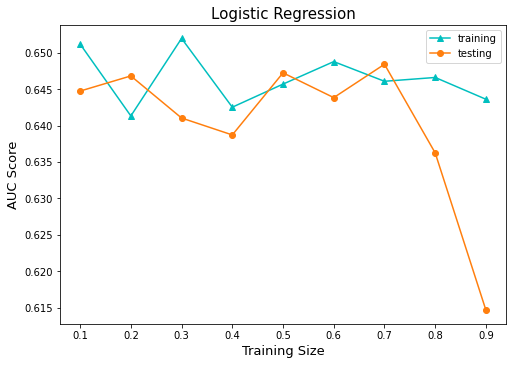

In [ ]:
AUC_Curve(classifier = Logistic, seed = 12,
          clf_name = 'Logistic Regression')

- ROC Curve based on the best training size retrieved from the AUC curve

No Skill : ROC AUC=0.500
Logistic : ROC AUC=0.652


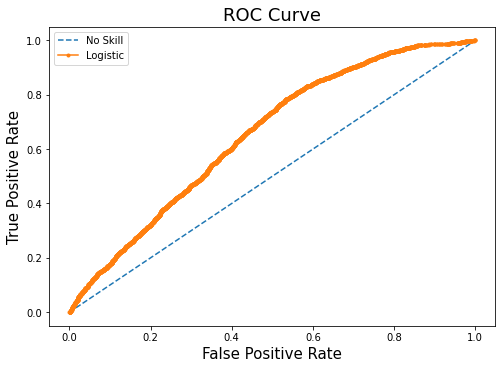

In [ ]:
ROC_Curve(classifier = Logistic, clf_name = 'Logistic', train_size = 0.7)

## Naive Bayes

In [ ]:
# Classification Model
NaiveBayes = GaussianNB()    
#NaiveBayes = MultinomialNB() 
#NaiveBayes = BernoulliNB()    

In [ ]:
# 10-fold Cross Validation Evaluation
CVClassifier_Eval(classifier = NaiveBayes, seed = 13)

Accuracy: 0.6448184287485098
Precision: 0.658648895414621
Recall: 0.7885654406489552
F-Measure: 0.717760467302138
Confusion Matrix:
[[ 4488  5439]
 [ 2814 10495]]


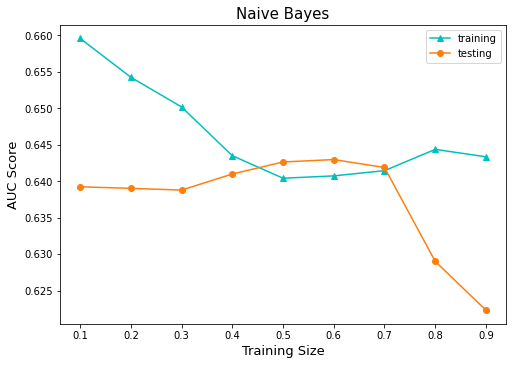

In [ ]:
AUC_Curve(classifier = NaiveBayes, seed = 29,
          clf_name = 'Naive Bayes')

No Skill : ROC AUC=0.500
Naive Bayes : ROC AUC=0.644


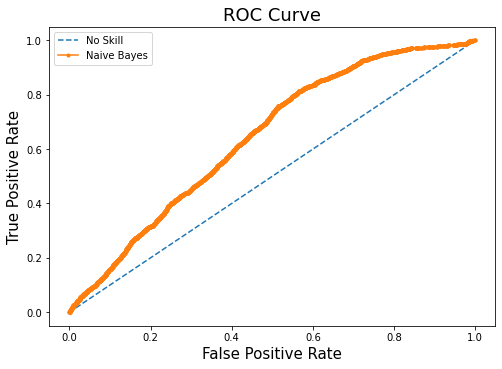

In [ ]:
ROC_Curve(classifier = NaiveBayes, clf_name = 'Naive Bayes', train_size = 0.7)

## Multi-layer Preceptrons

In [19]:
# Classification Model
MLP = MLPClassifier(hidden_layer_sizes=(8,8,8), 
                    activation='relu',
                    solver='adam', 
                    max_iter=1000)

In [20]:
# 10-fold Cross Validation Evaluation
CVClassifier_Eval(classifier = MLP, seed = 13)

Accuracy: 0.644217704715918
Precision: 0.6698857835041233
Recall: 0.7806784429141975
F-Measure: 0.7065472483469306
Confusion Matrix:
[[ 4015  5912]
 [ 2182 11127]]


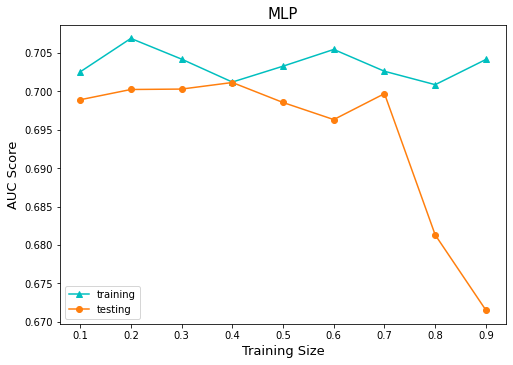

In [21]:
AUC_Curve(classifier = MLP, seed = 13, clf_name = 'MLP')

No Skill : ROC AUC=0.500
Multi-layer Preceptrons : ROC AUC=0.705


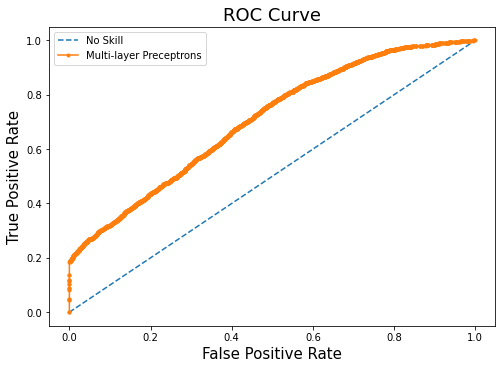

CPU times: user 5.52 s, sys: 113 ms, total: 5.63 s
Wall time: 5.52 s


In [22]:
%%time
ROC_Curve(classifier = MLP, clf_name = 'Multi-layer Preceptrons',
          train_size = 0.7)

## Support Vector Machines (SVM)

In [ ]:
# Classification Model
SVM = SVC(kernel = 'sigmoid', gamma = 'auto',
          random_state = 13, probability = True)

In [ ]:
%%time
# 10-fold Cross Validation Evaluation
CVClassifier_Eval(classifier = SVM, seed = 35)

Accuracy: 0.5727750186528044
Precision: 0.5727750186528044
Recall: 1.0
F-Measure: 0.7283622951392379
Confusion Matrix:
[[    0  9927]
 [    0 13309]]
CPU times: user 36min 51s, sys: 14.9 s, total: 37min 6s
Wall time: 37min 8s


CPU times: user 43min 8s, sys: 49.8 s, total: 43min 58s
Wall time: 44min


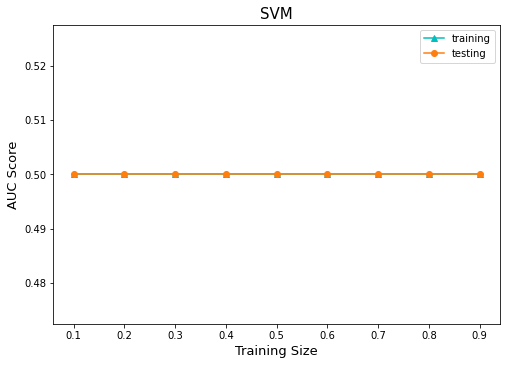

In [ ]:
%%time
AUC_Curve(classifier = SVM, seed = 12,
          clf_name = 'SVM')

No Skill : ROC AUC=0.500
SVM : ROC AUC=0.500


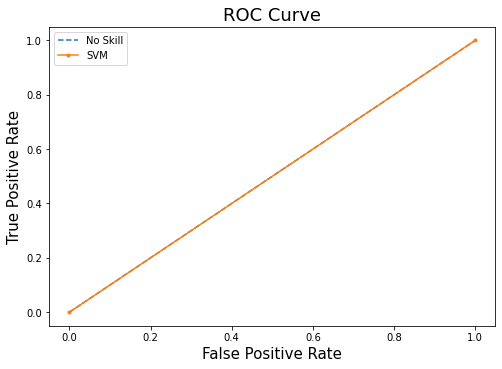

In [ ]:
ROC_Curve(classifier = SVM, clf_name = 'SVM', train_size = 0.7)

## K-Nearest Neighbors

In [ ]:
# Classification Model
KNN = KNeighborsClassifier(n_neighbors = 2) 

In [ ]:
# 10-fold Cross Validation Evaluation
CVClassifier_Eval(classifier = KNN, seed = 16)

Accuracy: 0.5247035371051885
Precision: 0.6355528865184139
Recall: 0.39897985007597886
F-Measure: 0.4901515739836575
Confusion Matrix:
[[6882 3045]
 [7999 5310]]


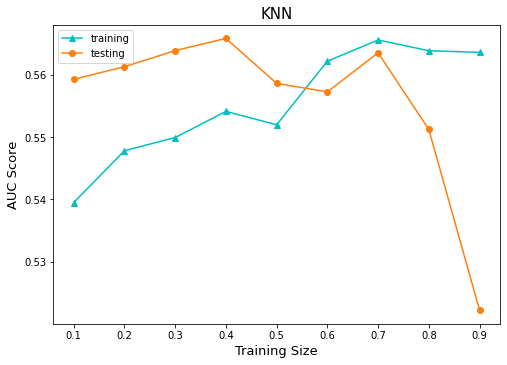

In [ ]:
AUC_Curve(classifier = KNN, seed = 12, clf_name = 'KNN')

No Skill : ROC AUC=0.500
KNN : ROC AUC=0.564


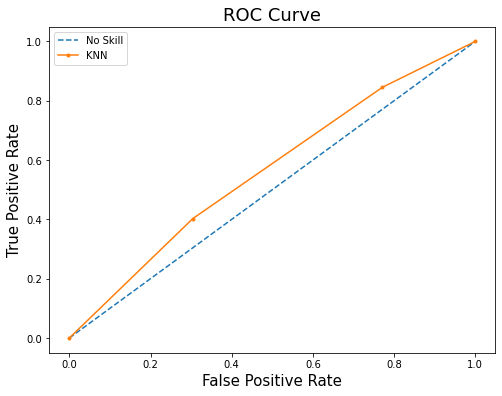

In [ ]:
ROC_Curve(classifier = KNN, clf_name = 'KNN', train_size = 0.7)

## Boosting

In [14]:
# Classification Model
Boosting = AdaBoostClassifier(random_state = 1,
                              n_estimators = 100,
                              learning_rate = 0.5)

In [17]:
# 10-fold Cross Validation Evaluation
CVClassifier_Eval(classifier = Boosting, seed = 33)

Accuracy: 0.657773551619923
Precision: 0.668013342681631
Recall: 0.800286572931201
F-Measure: 0.7281806807282456
Confusion Matrix:
[[ 4633  5294]
 [ 2658 10651]]


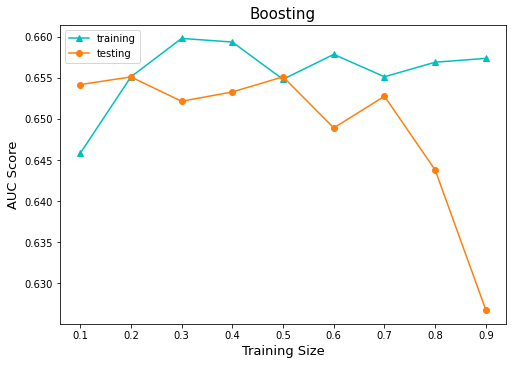

In [ ]:
AUC_Curve(classifier = Boosting, seed = 12, clf_name = 'Boosting')

No Skill : ROC AUC=0.500
Boosting : ROC AUC=0.712


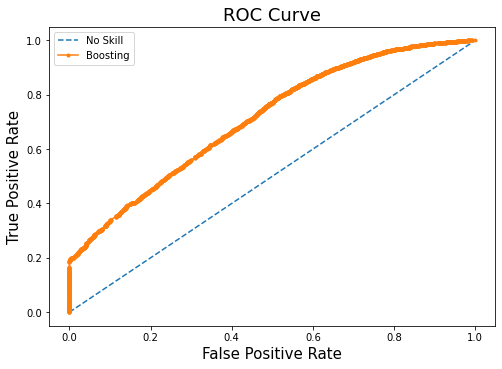

In [16]:
ROC_Curve(classifier = Boosting, clf_name = 'Boosting', train_size = 0.7)

##Bagging

In [8]:
# Classification Model
Bagging = BaggingClassifier(max_samples=0.5, bootstrap=True)

In [9]:
# 10-fold Cross Validation Evaluation
CVClassifier_Eval(classifier = Bagging, seed = 37)

Accuracy: 0.6043204118361398
Precision: 0.6660493247306023
Recall: 0.6234890381475853
F-Measure: 0.6499107889114553
Confusion Matrix:
[[5659 4268]
 [5015 8294]]


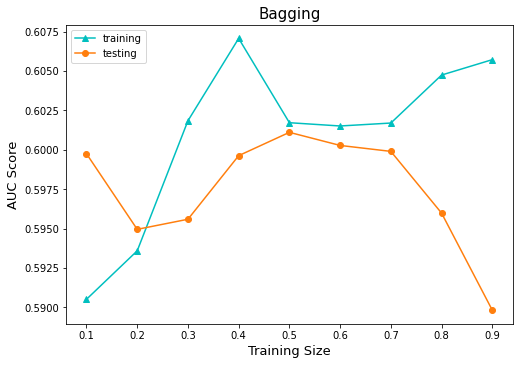

In [ ]:
AUC_Curve(classifier = Bagging, seed = 12,
          clf_name = 'Bagging')

No Skill : ROC AUC=0.500
Bagging : ROC AUC=0.664


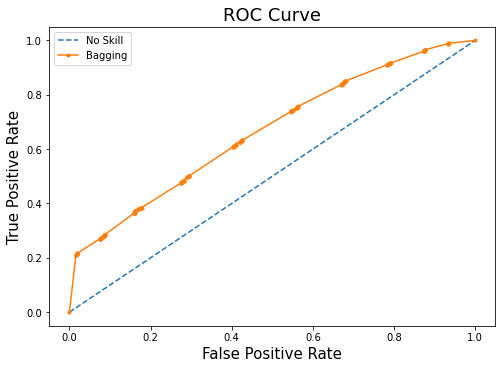

In [10]:
ROC_Curve(classifier = Bagging, clf_name = 'Bagging', train_size = 0.7)

## Decision Tree

In [ ]:
# Classification Model
DecisionTree = DecisionTreeClassifier(criterion = 'entropy', 
                                      min_samples_split = 50)

In [ ]:
# 10-fold Cross Validation Evaluation
CVClassifier_Eval(classifier = DecisionTree, seed = 43)

Accuracy: 0.6022545072362508
Precision: 0.6366900762150178
Recall: 0.7140286290482029
F-Measure: 0.6733508755613784
Confusion Matrix:
[[4492 5435]
 [3812 9497]]


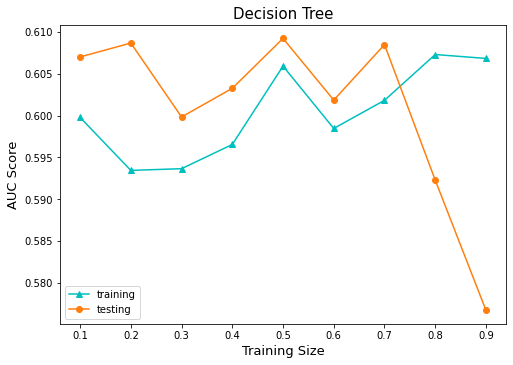

In [ ]:
AUC_Curve(classifier = DecisionTree, seed = 47,
          clf_name = 'Decision Tree')

No Skill : ROC AUC=0.500
Decision Tree : ROC AUC=0.613


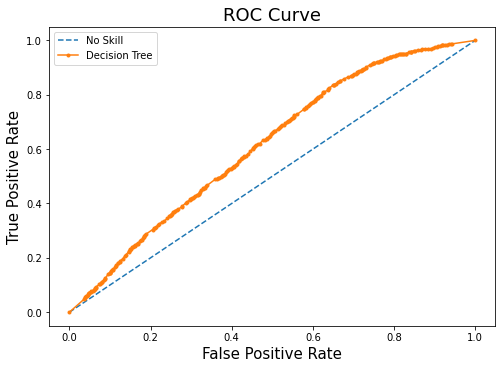

In [ ]:
ROC_Curve(classifier = DecisionTree, clf_name = 'Decision Tree', 
          train_size = 0.7)

## JRip

In [16]:
JRip = lw.RIPPER()

In [17]:
# 10-fold Cross Validation Evaluation
CVClassifier_Eval(classifier = JRip, seed = 42)

Accuracy: 0.539296346569477
Precision: 1.0
Recall: 0.2211343158798574
F-Measure: 0.29165454535120927
Confusion Matrix:
[[ 9331   596]
 [10092  3217]]


In [ ]:
AUC_Curve(classifier = JRip, seed = 47, clf_name = 'JRip')

base.py: .predict_proba: RuntimeWarning: 
Some examples lacked any rule with sufficient sample size to predict_proba: [9, 10, 11, 16, 20, 23, 27, 31, 48, 64, 65, 73, 76, 103, 110, 138, 140, 158, 160, 161, 164, 182, 212, 226, 237, 239, 240, 268, 270, 271, 285, 307, 316, 327, 338, 361, 363, 385, 387, 400, 407, 421, 439, 450, 455, 457, 458, 460, 462, 464, 465, 474, 497, 503, 508, 510, 515, 537, 538, 539, 544, 547, 558, 560, 566, 568, 569, 577, 592, 606, 610, 638, 641, 644, 653, 665, 675, 683, 687, 692, 704, 711, 728, 740, 746, 756, 774, 782, 785, 816, 820, 837, 838, 862, 864, 866, 913, 922, 923, 926, 936, 946, 952, 958, 992, 996, 1001, 1011, 1024, 1025, 1028, 1031, 1049, 1050, 1062, 1063, 1066, 1070, 1076, 1079, 1090, 1113, 1114, 1124, 1153, 1156, 1186, 1191, 1197, 1204, 1224, 1234, 1235, 1278, 1285, 1286, 1297, 1299, 1302, 1303, 1316, 1320, 1322, 1351, 1373, 1383, 1387, 1392, 1394, 1397, 1422, 1424, 1447, 1456, 1460, 1475, 1487, 1490, 1510, 1512, 1513, 1536, 1555, 1599, 1600, 1608, 1609,

No Skill : ROC AUC=0.500
JRip : ROC AUC=0.420


base.py: .predict_proba: RuntimeWarning: 
Some examples lacked any rule with sufficient sample size to predict_proba: [6, 9, 11, 24, 33, 48, 107, 119, 123, 127, 134, 140, 145, 148, 175, 177, 200, 202, 210, 223, 232, 236, 253, 269, 281, 283, 317, 322, 324, 334, 338, 353, 359, 363, 389, 391, 392, 396, 400, 409, 417, 440, 464, 501, 508, 512, 518, 527, 528, 533, 534, 545, 572, 593, 595, 600, 609, 619, 620, 628, 641, 665, 666, 679, 685, 716, 719, 720, 733, 740, 749, 750, 751, 772, 802, 809, 810, 811, 830, 840, 860, 875, 878, 896, 921, 929, 931, 933, 941, 959, 960, 972, 973, 983, 991, 992, 994, 995, 998, 1019, 1020, 1025, 1026, 1027, 1030, 1033, 1040, 1045, 1054, 1057, 1074, 1085, 1116, 1119, 1130, 1133, 1150, 1168, 1172, 1209, 1223, 1232, 1238, 1245, 1247, 1253, 1296, 1308, 1312, 1327, 1335, 1344, 1348, 1352, 1364, 1369, 1372, 1386, 1387, 1395, 1396, 1399, 1400, 1420, 1432, 1436, 1445, 1465, 1474, 1494, 1496, 1509, 1510, 1511, 1534, 1537, 1549, 1560, 1561, 1592, 1598, 1599, 1605, 1606, 1621

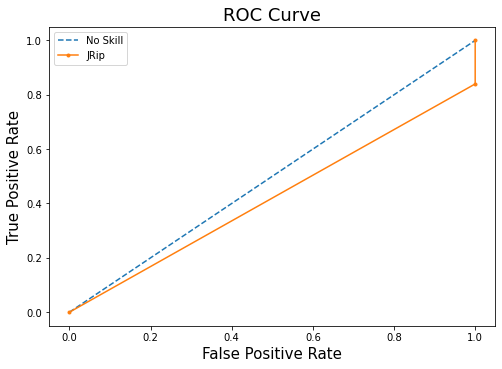

In [23]:
ROC_Curve(classifier = JRip, clf_name = 'JRip', train_size = 0.8)

## Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(random_state = 47)

In [13]:
%%time
# 10-fold Cross Validation Evaluation
CVClassifier_Eval(classifier = RF, seed = 42)

Accuracy: 0.6124988608267398
Precision: 0.6574977645529184
Recall: 0.6753339961473933
F-Measure: 0.6662556604727893
Confusion Matrix:
[[5244 4683]
 [4321 8988]]


CPU times: user 3min 50s, sys: 501 ms, total: 3min 51s
Wall time: 3min 51s


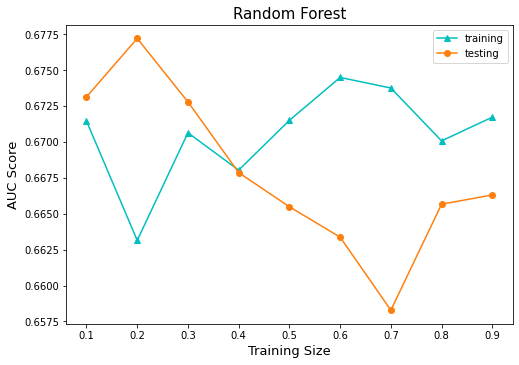

In [27]:
%%time
AUC_Curve(classifier = RF, seed = 4, clf_name = 'Random Forest')

No Skill : ROC AUC=0.500
Random Forest : ROC AUC=0.671


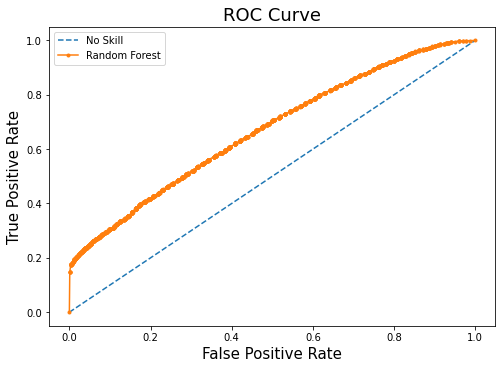

In [29]:
ROC_Curve(classifier = RF, 
          clf_name = 'Random Forest', train_size = 0.5)

## J48 (Failed)

In [ ]:
!pip install weka
from weka.classifiers import Classifier

J48 = Classifier(classname="weka.classifiers.trees.J48", 
                 options=["-C", "0.3"])

# Evaluate Classifications


In [3]:
Classifiers = ['NaïveBayes','MLP','Logistic','SVM','KNN','Boosting',
               'Bagging','JRip','RandomForest','DecisionTrees']

In [10]:
Py_AUC = [0.644,0.705,0.652,0.500,0.564,0.658,0.664,0.558,0.671,0.613]
Weka_AUC = [0.65,0.548,0.65,0.603,0.611,0.642,0.645,0.623,0.603,0.608]
AUC = pd.DataFrame([Py_AUC, Weka_AUC], columns= Classifiers, 
                   index = ['Python', 'Weka'])
# A table of AUC with 2 platform
AUC.transpose()
# Friedman test
ss.friedmanchisquare(*np.array(AUC.transpose()))
# Nemenyi test
#sp.posthoc_nemenyi_friedman(AUC.transpose())

FriedmanchisquareResult(statistic=8.231707317073162, pvalue=0.5109750462879252)

In [11]:
Py_F1 = [0.7177,0.7065,0.725,0.728,0.49,0.726,0.649,0.58,0.666,0.67]
Weka_F1 = [0.635,0.483,0.632,0.61,0.6,0.634,0.634,0.635,0.59,0.611]
F1 = pd.DataFrame([Py_F1, Weka_F1], columns= Classifiers, 
                  index = ['Python', 'Weka'])
# A table of F1 scores with 2 platform
F1.transpose()    
# Friedman test
ss.friedmanchisquare(*np.array(F1.transpose()))
# Nemenyi test
#sp.posthoc_nemenyi_friedman(F1.transpose())

FriedmanchisquareResult(statistic=9.32926829268292, pvalue=0.4074516774988835)

In [12]:
Py_accuracy = [0.6448,0.6442,0.6478,0.5727,0.5247,0.6488,0.6043,
               0.5601,0.6124,0.6022]
Weka_accuracy = [0.6466,0.4854,0.6479,0.6429,0.6074,0.6493,0.6493,
                 0.6483,0.5952,0.6344]
Accuracy = pd.DataFrame([Py_accuracy, Weka_accuracy], columns= Classifiers, 
                  index = ['Python', 'Weka'])
# A table of F1 scores with 2 platform
Accuracy.transpose()    
# Friedman test
ss.friedmanchisquare(*np.array(Accuracy.transpose()))
# Nemenyi test
#sp.posthoc_nemenyi_friedman(Accuracy.transpose())

FriedmanchisquareResult(statistic=11.188449848024318, pvalue=0.2630125772350686)